# Experimentos con el subconjunto de 10 clases

Este notebook replica el pipeline de `dataExperiments.ipynb` pero usando el pickle filtrado con las 10 clases (`Dataset/ucf101_2d_10cls.pkl`).
Ejecuta las celdas en orden: carga → dataset/transforms → dataloaders → entrenamiento mínimo → evaluación.

In [1]:
# Imports y rutas al pickle y mapping
import pickle
from pathlib import Path
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

ROOT = Path('.')
PICKLE_10CLS = ROOT / 'Dataset' / 'ucf101_2d_10cls.pkl'
MAPPING_FILE = ROOT / 'Dataset' / 'label_mapping_10cls.json'
print('Looking for filtered pickle at:', PICKLE_10CLS)

Looking for filtered pickle at: Dataset\ucf101_2d_10cls.pkl


In [2]:
# Carga del pickle filtrado y creación de df_ann + annotations_summary_10cls.csv
if not PICKLE_10CLS.exists():
    raise FileNotFoundError(f'Filtered pickle not found: {PICKLE_10CLS}. Run scripts/create_10class_subset.py first.')

with open(PICKLE_10CLS, 'rb') as f:
    data = pickle.load(f)

annotations = data.get('annotations') or []
print(f'Loaded {len(annotations)} annotations from filtered pickle')

rows = []
for ann in annotations:
    kp = ann.get('keypoint')
    kp_shape = None
    try:
        if kp is not None:
            kp_shape = np.array(kp).shape
    except Exception:
        kp_shape = None
    rows.append({
        'frame_dir': ann.get('frame_dir'),
        'total_frames': ann.get('total_frames'),
        'img_shape': ann.get('img_shape'),
        'original_shape': ann.get('original_shape'),
        'label': int(ann.get('label')) if ann.get('label') is not None else None,
        'keypoint_shape': kp_shape,
        'has_keypoint_score': ('keypoint_score' in ann) and (ann.get('keypoint_score') is not None)
    })

df_ann = pd.DataFrame(rows)
csv_path = 'annotations_summary_10cls.csv'
df_ann.to_csv(csv_path, index=False)
print(f'Saved annotations summary to {csv_path}')

if MAPPING_FILE.exists():
    with open(MAPPING_FILE, 'r', encoding='utf-8') as f:
        mapping = json.load(f)
    print('Loaded label mapping (old->new):', mapping)
else:
    mapping = None

df_ann.head()

# --- Performance optimization: pre-convert keypoints and scores to numpy arrays once ---
# This avoids repeated `np.array(...)` conversions inside Dataset.__getitem__ which are expensive.
print('Pre-converting keypoint lists to numpy arrays in memory (this may use RAM but speeds up __getitem__)')
for i, ann in enumerate(annotations):
    kp = ann.get('keypoint')
    if kp is not None and not hasattr(kp, 'shape'):
        try:
            ann['keypoint'] = np.asarray(kp, dtype=np.float32)
        except Exception:
            # leave as is if conversion fails
            ann['keypoint'] = kp
    # convert scores if present
    if 'keypoint_score' in ann and ann['keypoint_score'] is not None and not hasattr(ann['keypoint_score'], 'shape'):
        try:
            ann['keypoint_score'] = np.asarray(ann['keypoint_score'], dtype=np.float32)
        except Exception:
            pass

print('Done pre-conversion of keypoints.')

Loaded 1413 annotations from filtered pickle
Saved annotations summary to annotations_summary_10cls.csv
Loaded label mapping (old->new): {'10': 0, '16': 1, '25': 2, '59': 3, '89': 4, '88': 5, '7': 6, '55': 7, '38': 8, '12': 9}
Pre-converting keypoint lists to numpy arrays in memory (this may use RAM but speeds up __getitem__)
Done pre-conversion of keypoints.


In [3]:
# NormalizeKeypoints y UCFSkeletonDataset (igual al notebook original)
class NormalizeKeypoints:
    """Normalize keypoints to unit coordinates using image shape.
    Expects sample to contain 'keypoint' (torch.Tensor (T,V,C)) and either
    'img_shape' or 'original_shape' (height, width).
    """
    def __init__(self, shape_key='img_shape'):
        self.shape_key = shape_key
    def __call__(self, sample):
        kp = sample['keypoint']
        shape = sample.get(self.shape_key) or sample.get('original_shape')
        if shape is None:
            return sample
        try:
            h, w = float(shape[0]), float(shape[1])
            if w > 0 and h > 0:
                kp = kp.clone()
                kp[..., 0] = kp[..., 0] / w
                kp[..., 1] = kp[..., 1] / h
                sample['keypoint'] = kp
        except Exception:
            pass
        return sample

class UCFSkeletonDataset(Dataset):
    def __init__(self, annotations_list, transform=None, select_best_by_score=True, dtype=torch.float32):
        self.annotations = annotations_list
        self.transform = transform
        self.select_best_by_score = select_best_by_score
        self.dtype = dtype
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, idx):
        ann = self.annotations[idx]
        kp = ann.get('keypoint')
        kp_score = ann.get('keypoint_score', None)
        kp = np.array(kp)  # M x T x V x C
        if kp.ndim != 4:
            raise ValueError(f'Unexpected keypoint shape for idx={idx}: {kp.shape}')
        M = kp.shape[0]
        person_idx = 0
        if M > 1 and kp_score is not None and self.select_best_by_score:
            scores = np.array(kp_score)
            mean_scores = scores.mean(axis=(1,2))
            person_idx = int(mean_scores.argmax())
        person_kp = kp[person_idx]  # T x V x C
        tensor_kp = torch.from_numpy(person_kp.astype(np.float32))
        sample = {
            'keypoint': tensor_kp,
            'label': int(ann.get('label')) if ann.get('label') is not None else None,
            'frame_dir': ann.get('frame_dir'),
            'total_frames': ann.get('total_frames'),
            'img_shape': ann.get('img_shape'),
            'original_shape': ann.get('original_shape')
        }
        if kp_score is not None:
            score_np = np.array(kp_score)[person_idx]
            sample['score'] = torch.from_numpy(score_np.astype(np.float32))
        if self.transform is not None:
            sample = self.transform(sample)
        return sample

# instantiate normalize and test dataset
normalize = NormalizeKeypoints(shape_key='img_shape')
ds_full = UCFSkeletonDataset(annotations, transform=normalize)
print('Dataset length (10cls):', len(ds_full))
print('Example sample keys:', list(ds_full[0].keys()))

Dataset length (10cls): 1413
Example sample keys: ['keypoint', 'label', 'frame_dir', 'total_frames', 'img_shape', 'original_shape', 'score']


In [4]:
# Collate function (right-pad) y DataLoaders (small batch sizes recomendados)
def pad_sequence_kp_right(kps):
    T_max = max(t.shape[0] for t in kps)
    V = kps[0].shape[1]
    C = kps[0].shape[2]
    padded, masks = [], []
    for t in kps:
        T = t.shape[0]
        pad_len = T_max - T
        if pad_len > 0:
            pad_tensor = torch.zeros((pad_len, V, C), dtype=t.dtype)
            p = torch.cat([pad_tensor, t], dim=0)
            mask = torch.cat([torch.zeros((pad_len, V)), torch.ones((T, V))], dim=0)
        else:
            p = t
            mask = torch.ones((T, V))
        padded.append(p)
        masks.append(mask)
    batch_kp = torch.stack(padded, dim=0)
    batch_mask = torch.stack(masks, dim=0)
    return batch_kp, batch_mask

def ucf_collate_fn_right(batch):
    kps = [item['keypoint'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    frame_dirs = [item['frame_dir'] for item in batch]
    total_frames = [item['total_frames'] for item in batch]
    scores = [item.get('score') for item in batch]
    batch_kp, batch_mask = pad_sequence_kp_right(kps)
    batch_scores = None
    if any(s is not None for s in scores):
        scores_repl = []
        for i, s in enumerate(scores):
            if s is None:
                T = kps[i].shape[0]
                V = kps[i].shape[1]
                scores_repl.append(torch.zeros((T, V), dtype=torch.float32))
            else:
                scores_repl.append(s)
        T_max = batch_kp.shape[1]
        padded_scores = []
        for s in scores_repl:
            pad_len = T_max - s.shape[0]
            if pad_len > 0:
                pad = torch.zeros((pad_len, s.shape[1]), dtype=s.dtype)
                padded_scores.append(torch.cat([pad, s], dim=0))
            else:
                padded_scores.append(s)
        batch_scores = torch.stack(padded_scores, dim=0)
    return {'keypoint': batch_kp, 'mask': batch_mask, 'label': labels, 'frame_dir': frame_dirs, 'total_frames': total_frames, 'score': batch_scores}

# Create a simple train/val split and DataLoaders (small batches for GTX 1650)
indices = np.arange(len(annotations))
try:
    from sklearn.model_selection import train_test_split
    train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=df_ann['label'].values, random_state=42)
except Exception:
    rng = np.random.RandomState(42)
    perm = rng.permutation(len(indices))
    split = int(0.8 * len(indices))
    train_idx = perm[:split]
    val_idx = perm[split:]

train_anns = [annotations[i] for i in train_idx]
val_anns = [annotations[i] for i in val_idx]

train_ds = UCFSkeletonDataset(train_anns, transform=normalize)
val_ds = UCFSkeletonDataset(val_anns, transform=normalize)

# Performance: try pin_memory=True and experiment with num_workers (0..4). On Windows, spawn overhead can make small num_workers faster.
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=ucf_collate_fn_right, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=ucf_collate_fn_right, num_workers=0, pin_memory=True)
print('Created train/val DataLoaders — train size:', len(train_ds), 'val size:', len(val_ds))

Created train/val DataLoaders — train size: 1130 val size: 283


In [7]:
# Entrenamiento mínimo (1 época) que guarda lstm_10cls_minimal.pt (con weight decay básico)
import torch.nn as nn
from Models.lstm_model import SkeletonLSTM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = int(df_ann['label'].nunique())
model = SkeletonLSTM(num_joints=17, in_channels=2, num_classes=num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
n_epochs = 30
for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    for batch in train_loader:
        kp = batch['keypoint'].to(device)
        labels_b = batch['label'].to(device)
        optimizer.zero_grad()
        logits = model(kp)
        loss = criterion(logits, labels_b)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels_b.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == labels_b).sum().item()
        running_total += labels_b.size(0)
    train_loss = running_loss / running_total
    train_acc = running_correct / running_total
    print(f'Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}')
ckpt_path = 'lstm_10cls_minimal.pt'
torch.save({'model_state': model.state_dict(), 'num_classes': num_classes}, ckpt_path)
print('Saved checkpoint to', ckpt_path)

Epoch 1: train_loss=2.2345, train_acc=0.1655
Epoch 2: train_loss=1.9369, train_acc=0.2717
Epoch 2: train_loss=1.9369, train_acc=0.2717
Epoch 3: train_loss=1.8227, train_acc=0.3009
Epoch 3: train_loss=1.8227, train_acc=0.3009
Epoch 4: train_loss=1.6339, train_acc=0.3735
Epoch 4: train_loss=1.6339, train_acc=0.3735
Epoch 5: train_loss=1.5840, train_acc=0.3717
Epoch 5: train_loss=1.5840, train_acc=0.3717
Epoch 6: train_loss=1.9856, train_acc=0.2558
Epoch 6: train_loss=1.9856, train_acc=0.2558
Epoch 7: train_loss=1.7837, train_acc=0.3301
Epoch 7: train_loss=1.7837, train_acc=0.3301
Epoch 8: train_loss=1.7424, train_acc=0.3513
Epoch 8: train_loss=1.7424, train_acc=0.3513
Epoch 9: train_loss=1.5987, train_acc=0.3965
Epoch 9: train_loss=1.5987, train_acc=0.3965
Epoch 10: train_loss=1.5740, train_acc=0.3965
Epoch 10: train_loss=1.5740, train_acc=0.3965
Epoch 11: train_loss=1.4467, train_acc=0.4292
Epoch 11: train_loss=1.4467, train_acc=0.4292
Epoch 12: train_loss=1.4751, train_acc=0.4177
Epoch

Saved per-class metrics to per_class_metrics_10cls.csv


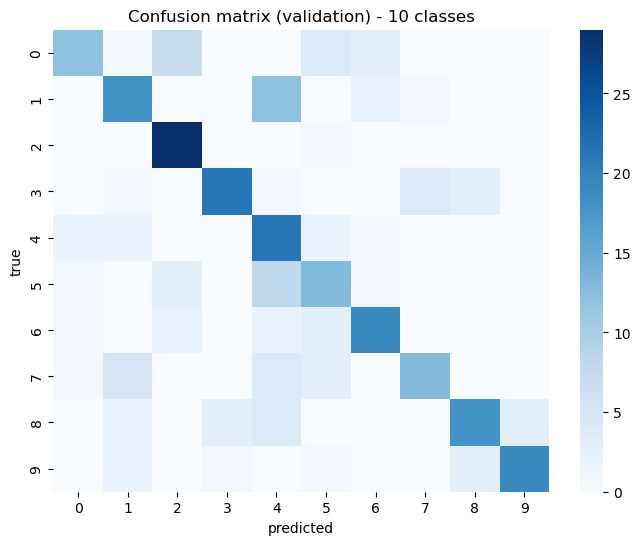

In [8]:
# Evaluación que guarda per_class_metrics_10cls.csv y muestra la matriz de confusión
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar checkpoint (si no está cargado ya)
ckpt = 'lstm_10cls_minimal.pt'
if not Path(ckpt).exists():
    raise FileNotFoundError(f'Checkpoint not found: {ckpt}. Run the training cell first.')
model.load_state_dict(torch.load(ckpt, map_location=device)['model_state'])
model.to(device)
model.eval()
all_y, all_pred = [], []
with torch.no_grad():
    for batch in val_loader:
        kp = batch['keypoint'].to(device)
        labels_b = batch['label'].to(device)
        logits = model(kp)
        preds = logits.argmax(dim=1)
        all_y.append(labels_b.cpu().numpy())
        all_pred.append(preds.cpu().numpy())
all_y = np.concatenate(all_y)
all_pred = np.concatenate(all_pred)
labels_unique = np.unique(all_y)
precision, recall, f1, support = precision_recall_fscore_support(all_y, all_pred, labels=labels_unique, zero_division=0)
per_class = pd.DataFrame({'label': labels_unique, 'precision': precision, 'recall': recall, 'f1': f1, 'support': support})
per_class.to_csv('per_class_metrics_10cls.csv', index=False)
print('Saved per-class metrics to per_class_metrics_10cls.csv')
cm = confusion_matrix(all_y, all_pred, labels=labels_unique)
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d')
plt.title('Confusion matrix (validation) - 10 classes')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()